In [1]:
%env PURE_PYTHON True
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from BTrees.OOBTree import OOBTree
import numpy as np
from collections import Counter
from scipy import stats
import pandas as pd
import pprint
import timeit

CHUNKS_SIZE = 10000
KEY_LENGTH = 8
ALPHABET = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

env: PURE_PYTHON=True


## Let's write an extenstion for doing a random walk, supporting the 3 approches in the article
We will use WALKING_TECHNIQUE enum to try every different approach.


In [2]:
from collections import Counter
import numpy as np
from BTrees.OOBTree import OOBTree


_debug_random_sampling = []


class WALKING_TECHNIQUE:
    RANDOM = 'random'
    RANDOM_WITH_TEST = 'random_with_test'
    OLKEN_EARLY_ABORT = 'olken_early_abort'
    DISTRIBUTION_ORIENTED = 'distribution_oriented'


class OOBTreeExt(OOBTree):

    def __init__(self):
        super(OOBTreeExt, self).__init__()
        self.walking_path_to_fanout_distribution = {}

    def random_sampling(self, k, how_to_walk):
        self.walking_path_to_fanout_distribution = {}
        all_accept_reject_measures = {
            'accept': [],
            'reject': [],
            'revisited_paths': Counter()
        }

        k = min(len(self), k)
        sampled_values = []
        all_walking_paths_set = set()
        while len(sampled_values) < k:
            sampled_value, walking_path, acc_rej_test_acceptance_prob = \
                self._get_value_and_path_by_random_walk_from_node(node=self,
                    how_to_walk=how_to_walk)

            if _this_value_was_sampled_already(walking_path, all_walking_paths_set):
                all_accept_reject_measures['revisited_paths'][str(walking_path)] += 1
                continue

            accept_reject_measures = {
                'path': walking_path,
                'value': sampled_value,
                'acceptance_prob': acc_rej_test_acceptance_prob
            }

            if how_to_walk == WALKING_TECHNIQUE.RANDOM_WITH_TEST and not _accept_reject_test_pass(
                    acc_rej_test_acceptance_prob):
                all_accept_reject_measures['reject'].append(accept_reject_measures)
                continue

            all_accept_reject_measures['accept'].append(accept_reject_measures)

            all_walking_paths_set.add(str(walking_path))
            sampled_values.append(sampled_value)

        add_to_debug_global(locals())

        return sampled_values

    def _get_value_and_path_by_random_walk_from_node(self, node, how_to_walk):
        walking_path = []
        current_node = node
        acc_rej_test_acceptance_prob = 1
        acc_rej_test_max_fan_out = None

        while not isinstance(current_node, self._bucket_type):
            if how_to_walk == WALKING_TECHNIQUE.RANDOM_WITH_TEST:
                acc_rej_test_max_fan_out = self.max_internal_size
                next_random_step = np.random.randint(low=0, high=current_node.size)
            elif how_to_walk == WALKING_TECHNIQUE.DISTRIBUTION_ORIENTED:
                next_random_step = self._random_next_move_respect_fanout_prob(current_node, walking_path)
            else:
                assert how_to_walk == WALKING_TECHNIQUE.RANDOM
                next_random_step = np.random.randint(low=0, high=current_node.size)

            current_node = current_node._data[next_random_step].child

            if how_to_walk == WALKING_TECHNIQUE.RANDOM_WITH_TEST:
                acc_rej_test_acceptance_prob *= (current_node.size / acc_rej_test_max_fan_out)

            walking_path.append((next_random_step, current_node.size, acc_rej_test_max_fan_out))

        next_random_step = np.random.randint(low=0, high=current_node.size)
        walking_path.append((next_random_step, current_node.size, acc_rej_test_max_fan_out))

        leaf = current_node._keys
        return leaf[next_random_step], walking_path, acc_rej_test_acceptance_prob

    def _get_path_to_bucket_of_value(self, key):
        path = []
        current_node = self._data

        index = self._search(key)
        # TODO: im not sure what _search('M') return 0, check it
        if index >= 0:  # TODO: else?
            if isinstance(self._data[index].child, self._bucket_type):
                index_in_leaf = _find_first_greather_value_in_list(self._data[index].child._values,
                    key)
                return [index, index_in_leaf]
            path_from_child = self._data[index].child._get_path_to_bucket_of_value(key)
            path_from_child = [index] + path_from_child
        else:
            raise  # TODO!
        return path_from_child


    def _random_next_move_respect_fanout_prob(self, current_node, walking_path):
        walking_path_str = str(walking_path)
        if walking_path_str in self.walking_path_to_fanout_distribution:
            node_distribution = self.walking_path_to_fanout_distribution[walking_path_str]
        else:
            all_sizes = np.array([node.child.size for node in current_node._data])
            node_distribution = all_sizes / sum(all_sizes)
            self.walking_path_to_fanout_distribution[walking_path_str] = node_distribution

        return np.random.choice(current_node.size, p=node_distribution)


def _find_first_greather_value_in_list(sorted_list, key):
    values_greater_than_key = [index for index, val in enumerate(sorted_list) if val >= key]
    if values_greater_than_key:
        return values_greater_than_key[0]
    return len(sorted_list) - 1


def add_to_debug_global(all_vars):
    global _debug_random_sampling
    _debug_random_sampling.append({
        'params': {
            'k': all_vars['k'],
            'how_to_walk': all_vars['how_to_walk'],
        },
        'all_accept_reject_measures': all_vars['all_accept_reject_measures']
    })


def _this_value_was_sampled_already(walking_path, all_walking_paths_set):
    return str(walking_path) in all_walking_paths_set


def _get_max_fan_out_for_(current_node):
    return np.max([node_data.child.size for node_data in current_node._data])


def _accept_reject_test_pass(acceptance_prob):
    rand_num = np.random.random_sample()
    return rand_num < acceptance_prob



In [3]:
def generate_btree_index_x_values_with_dist(num_of_values, disired_prefix_to_percent_dist):
    my_index = OOBTreeExt()
    for prefix, amount_percent in disired_prefix_to_percent_dist.items():
        amount = int(num_of_values * amount_percent)
        my_index = insert_to_index_random(my_index, amount, prefix)
    
    return my_index


def insert_to_index_random(my_index, amount, prefix=''):
    amount_in_iteration = min(CHUNKS_SIZE, amount)
    print('generating %s values, chunk of %s, with prefix=\'%s\'' %(amount, amount_in_iteration, prefix))

    proceed = 0
    for i in range(0, amount, amount_in_iteration):
        alphabet = list(ALPHABET)
        np_alphabet = np.array(alphabet)
        np_codes = np.random.choice(np_alphabet, [amount_in_iteration, KEY_LENGTH])
        my_index.update({
            prefix + ''.join(np_codes[i]): "".join(np_codes[i])
            for i in range(len(np_codes))
        })

        proceed += amount_in_iteration
        if (proceed % 150000) == 0:
            print('done generating %s values' % (proceed))
    return my_index

## Tools for analyze results

In [4]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def _calculate_prefix_ditribution(values):
    return {value: occurences/len(values) for value, occurences in Counter([key[:4] for key in values]).most_common(10)}

def _compute_kl_divergence_and_other_to_df(df):
    dist_vec_real = df[['gggg','hhhh','mmmm','rrrr']].values[0]
    df['other'] = 1 - df[['gggg', 'hhhh', 'mmmm', 'rrrr']].sum(axis=1)
    df['kl_diver_from_real'] = df[['gggg','hhhh','mmmm','rrrr']].apply(kl_divergence, axis=1, args=(dist_vec_real,))
    return df

def _draw_plots_comparing_algo_to_real(how_to_walk, df):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
    for i, sample_size in enumerate([500, 5000, 10000]):
        # TODO: instead of None, write explicity access to the row with the real values
        df_by_walk = df[df['how_to_walk'].isin([how_to_walk, None])] 
        df_by_walk_and_sample = df_by_walk[df_by_walk['sample_size'].isin([sample_size,1_000_000])]
        df_by_walk_and_sample = df_by_walk_and_sample.drop(
            ['sample_size' ,'kl_diver_from_real','running_time'], axis=1)
        df_by_walk_and_sample.plot(kind='bar', ax=axes[i], x='id')



def _random_sampling_to_measure(my_index, how_to_walk, df, sample_sizes=None, times_each=None):
    sample_sizes = sample_sizes or (500, 5_000, 10_000)
    times_each = times_each or list(range(3))
    for sample_size in sample_sizes:
        for i in times_each:
            print (f'i={i}, sample_size={sample_size}')
            start_time = timeit.default_timer()
            samples = my_index.random_sampling(k=sample_size, how_to_walk=how_to_walk)
            time_passed = timeit.default_timer() - start_time
            assert len(samples) == sample_size
            samples_dist = _calculate_prefix_ditribution(samples)
            df = df.append([
                {'id': f'sampled_{sample_size}_round_{i}', 'how_to_walk': how_to_walk, 'sample_size': sample_size ,
                 'running_time': time_passed,
                 **{x:y for x,y in samples_dist.items() if x in prefix_to_percent}}])
            print (f'i={i}, sample_size={sample_size}')
    return df


## Creating the synthetic data

In [5]:
prefix_to_percent = {
    'gggg': 0.25,
    'hhhh': 0.15,
    'mmmm': 0.10,
    'rrrr': 0.03,
    '': 0.47
}
num_of_values = 1_000_000
my_index = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent)

#my_index_backup_values = list(my_index.keys())


generating 250000 values, chunk of 10000, with prefix='gggg'
done generating 150000 values
generating 150000 values, chunk of 10000, with prefix='hhhh'
done generating 150000 values
generating 100000 values, chunk of 10000, with prefix='mmmm'
generating 30000 values, chunk of 10000, with prefix='rrrr'
generating 470000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values


In [6]:
prefix_to_percent_abs = {key:int(value * num_of_values) for key, value in prefix_to_percent.items()}
results_data_distribution = Counter([key[:4] if key[:4] in prefix_to_percent else '' for key in my_index.keys()])

assert prefix_to_percent_abs == results_data_distribution

In [7]:
results_prefix_to_percent = {key:value / num_of_values for key, value in results_data_distribution.items()}

In [8]:
results_prefix_to_percent

{'': 0.47, 'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03}

In [9]:
my_index_c = OOBTreeExt()
my_index_c.update({key:key for key in my_index.keys()})
my_index = my_index_c

## Random Sampling - Walk B+ Tree According to Fan-Outs distribution

In [10]:
random_sampling_df = _random_sampling_to_measure(my_index, how_to_walk=WALKING_TECHNIQUE.DISTRIBUTION_ORIENTED, df=pd.DataFrame())

i=0, sample_size=500
i=0, sample_size=500
i=1, sample_size=500
i=1, sample_size=500
i=2, sample_size=500
i=2, sample_size=500
i=0, sample_size=5000
i=0, sample_size=5000
i=1, sample_size=5000
i=1, sample_size=5000
i=2, sample_size=5000
i=2, sample_size=5000
i=0, sample_size=10000
i=0, sample_size=10000
i=1, sample_size=10000
i=1, sample_size=10000
i=2, sample_size=10000
i=2, sample_size=10000


In [22]:
random_sampling_df = _compute_kl_divergence_and_other_to_df(random_sampling_df)
random_sampling_df[random_sampling_df['how_to_walk'].isin([WALKING_TECHNIQUE.DISTRIBUTION_ORIENTED,None])]

,id,how_to_walk,sample_size,running_time,gggg,hhhh,mmmm,rrrr,other,kl_diver_from_real
0,sampled_500_round_0,distribution_oriented,500,0.290808,0.2600,0.1500,0.0960,0.0280,0.4660,0.000000
0,sampled_500_round_1,distribution_oriented,500,0.294439,0.2520,0.1480,0.1060,0.0320,0.4620,0.004914
0,sampled_500_round_2,distribution_oriented,500,0.290392,0.2840,0.1480,0.1100,0.0300,0.4280,0.040133
0,sampled_5000_round_0,distribution_oriented,5000,0.775297,0.2506,0.1438,0.1032,0.0332,0.4692,-0.002179
0,sampled_5000_round_1,distribution_oriented,5000,0.777091,0.2512,0.1490,0.1028,0.0330,0.4640,0.002811
0,sampled_5000_round_2,distribution_oriented,5000,0.861473,0.2498,0.1466,0.0990,0.0286,0.4760,-0.009706
0,sampled_10000_round_0,distribution_oriented,10000,1.321643,0.2556,0.1481,0.0954,0.0283,0.4726,-0.006547
0,sampled_10000_round_1,distribution_oriented,10000,1.306913,0.2580,0.1442,0.1053,0.0303,0.4622,0.004450
0,sampled_10000_round_2,distribution_oriented,10000,1.300384,0.2499,0.1536,0.1040,0.0317,0.4608,0.006000


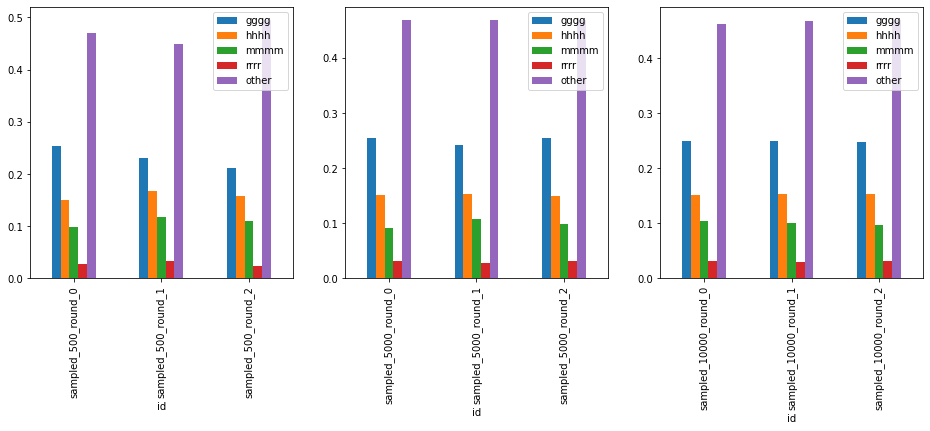

In [12]:
_draw_plots_comparing_algo_to_real(how_to_walk=WALKING_TECHNIQUE.DISTRIBUTION_ORIENTED ,df=random_sampling_df)

In [19]:
import random
new_index_shuffled = OOBTreeExt()
shuflled_values = list(my_index.items())
print(shuflled_values[:5])
random.shuffle(shuflled_values)
print(shuflled_values[:5])
new_index_shuffled.update(shuflled_values)
#random_sampling_df = _random_sampling_to_measure(my_index, how_to_walk=WALKING_TECHNIQUE.DISTRIBUTION_ORIENTED, df=pd.DataFrame())

[('AAAENrTS', 'AAAENrTS'), ('AAAgyfdn', 'AAAgyfdn'), ('AABBUcCt', 'AABBUcCt'), ('AABIjyVK', 'AABIjyVK'), ('AABwNwxG', 'AABwNwxG')]
[('thbUAIlc', 'thbUAIlc'), ('hhhhLHhYfqVF', 'hhhhLHhYfqVF'), ('rrrrmfdOsITs', 'rrrrmfdOsITs'), ('cIhTcmKP', 'cIhTcmKP'), ('CheuYHsB', 'CheuYHsB')]


In [28]:
random_sampling_df = None
random_sampling_df = _random_sampling_to_measure(new_index_shuffled, how_to_walk=WALKING_TECHNIQUE.DISTRIBUTION_ORIENTED, df=pd.DataFrame())

i=0, sample_size=500
i=0, sample_size=500
i=1, sample_size=500
i=1, sample_size=500
i=2, sample_size=500
i=2, sample_size=500
i=0, sample_size=5000
i=0, sample_size=5000
i=1, sample_size=5000
i=1, sample_size=5000
i=2, sample_size=5000
i=2, sample_size=5000
i=0, sample_size=10000
i=0, sample_size=10000
i=1, sample_size=10000
i=1, sample_size=10000
i=2, sample_size=10000
i=2, sample_size=10000


KeyError: "['kl_diver_from_real'] not found in axis"

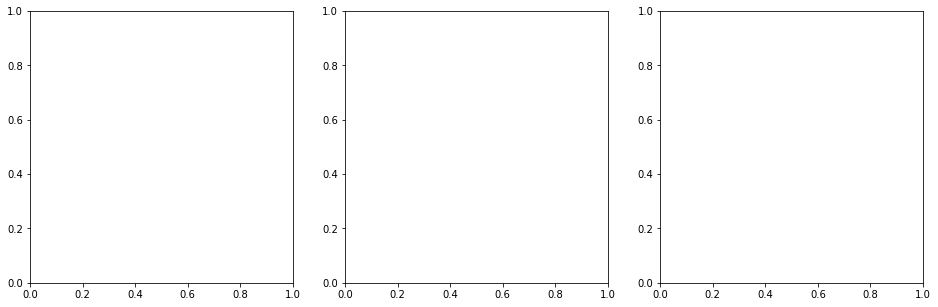

In [29]:
_draw_plots_comparing_algo_to_real(how_to_walk=WALKING_TECHNIQUE.DISTRIBUTION_ORIENTED ,df=random_sampling_df)

In [30]:
print(prefix_to_percent)
random_sampling_df[random_sampling_df['how_to_walk'].isin([WALKING_TECHNIQUE.DISTRIBUTION_ORIENTED,None])]

{'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03, '': 0.47}


,id,how_to_walk,sample_size,running_time,gggg,hhhh,mmmm,rrrr
0,sampled_500_round_0,distribution_oriented,500,0.304887,0.2680,0.1480,0.1060,0.0340
0,sampled_500_round_1,distribution_oriented,500,0.281990,0.2380,0.1580,0.1080,0.0440
0,sampled_500_round_2,distribution_oriented,500,0.305320,0.2240,0.1520,0.1020,0.0340
0,sampled_5000_round_0,distribution_oriented,5000,0.806532,0.2584,0.1544,0.0964,0.0318
0,sampled_5000_round_1,distribution_oriented,5000,0.855773,0.2552,0.1468,0.0992,0.0256
0,sampled_5000_round_2,distribution_oriented,5000,0.825768,0.2512,0.1498,0.1024,0.0302
0,sampled_10000_round_0,distribution_oriented,10000,1.398285,0.2485,0.1584,0.1012,0.0313
0,sampled_10000_round_1,distribution_oriented,10000,1.267143,0.2466,0.1573,0.0962,0.0300
0,sampled_10000_round_2,distribution_oriented,10000,1.320478,0.2523,0.1489,0.1022,0.0307


### Comparing all the algorithms again, we another data distribution

In [32]:
prefix_to_percent_small = {
    'gggg': 0.07,
    'hhhh': 0.04,
    'mmmm': 0.05,
    'rrrr': 0.03,
    '': 0.81
}
num_of_values = 1_000_000
my_index_small = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent_small)


generating 70000 values, chunk of 10000, with prefix='gggg'
generating 40000 values, chunk of 10000, with prefix='hhhh'
generating 50000 values, chunk of 10000, with prefix='mmmm'
generating 30000 values, chunk of 10000, with prefix='rrrr'
generating 810000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values


In [33]:
random_sampling_small_df = pd.DataFrame([{'id': 'real', 'how_to_walk': None, 'sample_size': len(my_index_small), **prefix_to_percent_small}])
random_sampling_small_df.rename(columns={'': 'other'}, inplace=True)



In [34]:
random_sampling_small_df = _random_sampling_to_measure(my_index_small, how_to_walk=WALKING_TECHNIQUE.RANDOM_WITH_TEST, df=random_sampling_small_df)


i=0, sample_size=500
i=1, sample_size=500
i=2, sample_size=500
i=0, sample_size=5000
i=1, sample_size=5000
i=2, sample_size=5000
i=0, sample_size=10000
i=1, sample_size=10000
i=2, sample_size=10000


In [35]:
random_sampling_small_df = _compute_kl_divergence_and_other_to_df(random_sampling_small_df)

In [36]:
random_sampling_small_df

,id,how_to_walk,sample_size,gggg,hhhh,mmmm,rrrr,other,running_time,kl_diver_from_real
0,real,None,1000000,0.0700,0.0400,0.0500,0.0300,0.8100,NaN,0.000000
0,sampled_500_round_0,random_with_test,500,0.0640,0.0320,0.0520,0.0420,0.8100,0.527243,0.003296
0,sampled_500_round_1,random_with_test,500,0.0840,0.0340,0.0440,0.0240,0.8140,0.500578,-0.001191
0,sampled_500_round_2,random_with_test,500,0.0580,0.0500,0.0320,0.0240,0.8360,0.501669,-0.019386
0,sampled_5000_round_0,random_with_test,5000,0.0704,0.0358,0.0554,0.0326,0.8058,4.300277,0.004821
0,sampled_5000_round_1,random_with_test,5000,0.0732,0.0406,0.0532,0.0278,0.8052,4.431451,0.005060
0,sampled_5000_round_2,random_with_test,5000,0.0720,0.0422,0.0514,0.0262,0.8082,6.208454,0.002159
0,sampled_10000_round_0,random_with_test,10000,0.0723,0.0351,0.0535,0.0298,0.8093,8.620541,0.001171
0,sampled_10000_round_1,random_with_test,10000,0.0699,0.0403,0.0527,0.0318,0.8053,8.753753,0.004826
0,sampled_10000_round_2,random_with_test,10000,0.0655,0.0410,0.0543,0.0302,0.8090,8.788469,0.001341


In [66]:
from datetime import datetime
s = datetime.utcnow()

2.479847